<a href="https://colab.research.google.com/github/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Chapter_2_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2 - Classification

For a classification problem, we want to build a model that can learn how different features (properties) of a system contribute **qualitatively** to that system, i.e. which features are characteristic for a certain class of objects.

The typical architecture of such an ANN is:

| Layer      | Description |
| ---------- | ----------- |
| Input      |Takes numeric coded features as input|
| Hidden     |Optional dense layers|
| Output     |Non-linear output to predict probabilities|
|Loss function|Cross entropy|


<img src="https://github.com/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Images/Classification%20network%20topology.jpg?raw=true" width="740" height="460" />

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

# Set figure style
sns.set(style="ticks")

# Binary classification

In the first section, we will build a model that can predict whether a cell belongs to Mycobacteria or Corynebacteria based on the measured cell size and cell density.

We will cover the following basic concepts:
- How can we transfer our ANN constructed for a regression problem to a binary classification problem?
- How can we use the validation holdout method to monitor how our model performs on unseen data?


**First, we create a toy data set representing populations of 2 different bacteria (500 cells each)**.

The cell size of each cell is plotted against the cell density.

Labels:
- 0 - Mycobacterium
- 1 - Corynebacterium

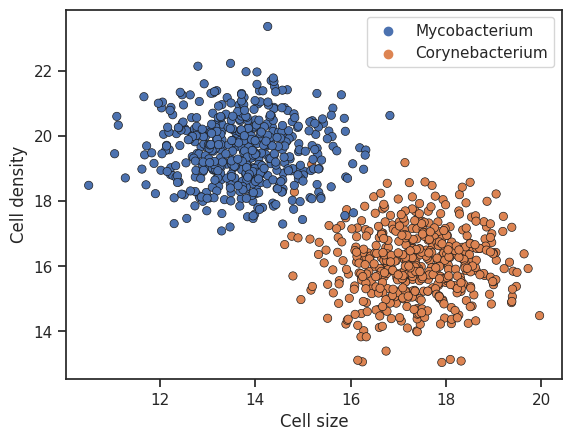

In [3]:
# Create toy data set
from sklearn.datasets import make_blobs

# Create clusters
X_total, y_total = make_blobs(n_samples=1000,
                              centers=2,
                              center_box=(10,20),
                              cluster_std=1,
                              random_state=42,
                              shuffle=True)

# Convert labels (0,1) to names
y_names = []
for i in y_total:
  if i == 0:
    y_names.append("Mycobacterium")
  else:
    y_names.append("Corynebacterium")

# Visualize data set
sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, edgecolor="k")
plt.xlabel("Cell size")
plt.ylabel("Cell density");

---
❓**Question**: How would a human solve the classification problem? How would a machine solve it?

---

**Now we draw a function that can separate the two cell clusters.**

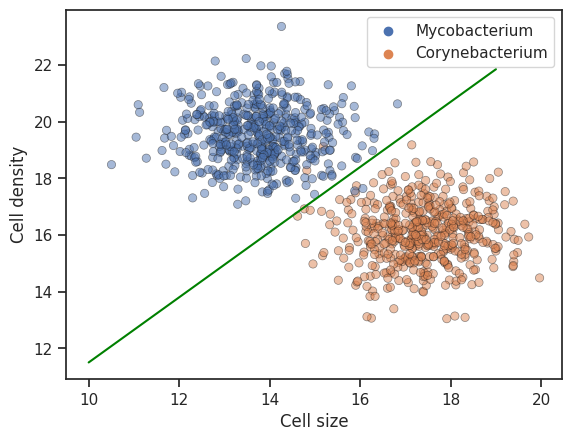

In [4]:
# Create a line to separate the clusters with slope m and intercept n
m = 1.15
n = 0
x_line = np.arange(10,20,1)
y_line = m*x_line + n

# Visualize data set
sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, alpha=0.5, edgecolor="k")
plt.plot(x_line, y_line, color="green")
plt.xlabel("Cell size")
plt.ylabel("Cell density");

Now we can measure **accuracy**. This metric tells us how often the predicted label is the same as the true label.

> $Accuracy = \frac {\text {Number correct predictions}} {\text {Number total predictions}}$

In [5]:
# Define number of wrong predictions (y_pred_wrong)
# and number of total predictions (y_pred_total)
y_pred_wrong = 4
y_pred_total = 1000

y_pred_correct = y_pred_total - y_pred_wrong
accuracy = y_pred_correct / y_pred_total
print(f"Accuracy = {accuracy*100} %")

Accuracy = 99.6 %


**Now we will split the data set into three parts: train (70%), test (20%), validation (10%).**
<img src="https://github.com/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Images/Holdout%20validation.jpg?raw=true" width="740" height="460" />

In [6]:
# Split data set into train, test and validation set
X_train, X_test, y_train, y_test = train_test_split(X_total,
                                                    y_total,
                                                    train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  train_size=0.875)

# Check the split and put all values in dataframe
data = [[X_train.shape, len(X_train), 100 * len(X_train) / len(X_total)],
        [y_train.shape, len(y_train), 100 * len(y_train) / len(y_total)],
        [X_test.shape, len(X_test), 100 * len(X_test) / len(X_total)],
        [y_test.shape, len(y_test), 100 * len(y_test) / len(y_total)],
        [X_val.shape, len(X_val), 100 * len(X_val) / len(X_total)],
        [y_val.shape, len(y_val), 100 * len(y_val) / len(y_total)]]
index = ["X_train", "y_train","X_test", "y_test","X_val", "y_val",]
columns = ["Shape", "Elements", "Percentage"]
pd.DataFrame(data=data,
             columns=columns,
             index=index)

Shape  Elements  Percentage
X_train  (700, 2)       700        70.0
y_train    (700,)       700        70.0
X_test   (200, 2)       200        20.0
y_test     (200,)       200        20.0
X_val    (100, 2)       100        10.0
y_val      (100,)       100        10.0

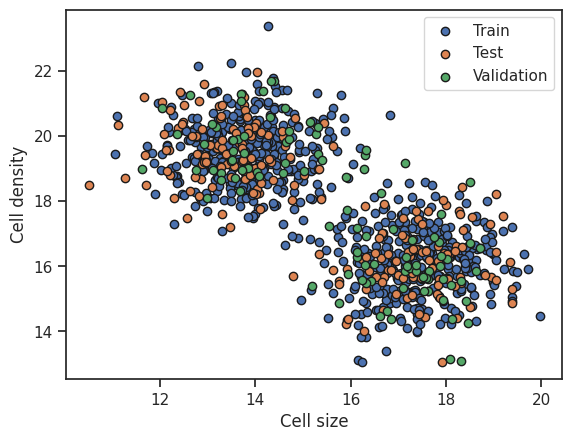

In [8]:
# Visualize data sets
plt.scatter(X_train[:,0],X_train[:,1], label="Train", edgecolor="k")
plt.scatter(X_test[:,0],X_test[:,1], label="Test", edgecolor="k")
plt.scatter(X_val[:,0],X_val[:,1], label="Validation", edgecolor="k")
plt.legend()
plt.xlabel("Cell size")
plt.ylabel("Cell density");

---
Let's build our first neural network with the following components:
* **1 single dense neuron** (input and output are together)
* Sigmoid activation function **$f(x) = \frac {1}{1+e^{-x}}$**.
* Optimizer is **Stochastic Gradient Descent SGD**.
* Loss function to minimize: **Binary Crossentropy**
* Metrics to monitor during training: **Accuracy**
* Validation set **(X_val, y_val)**
* Train model for **5 epochs**

<img src="https://github.com/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Images/Binary%20classification%20model%201.jpg?raw=true" width="740" height="460" />

In [9]:
# Set up random seed for reproducibility
tf.random.set_seed(42)

# Create model
model_1 = keras.Sequential([
    keras.Input(shape=(X_train.shape[1:])),
    layers.Dense(units=1, activation="sigmoid")
    ])

model_1.summary()

# Compile model
model_1.compile(optimizer="sgd",
                loss=keras.losses.BinaryCrossentropy(),
                metrics=["accuracy"])

# Fit model
history_1 = model_1.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
22/22 [==============================] - 1s 13ms/step - loss: 1.1672 - accuracy: 0.7657 - val_loss: 0.4392 - val_accuracy: 0.9900
Epoch 2/5
22/22 [==============================] - 0s 4ms/step - loss: 0.3821 - accuracy: 0.9829 - val_loss: 0.3735 - val_accuracy: 0.8700
Epoch 3/5
22/22 [==============================] - 0s 3ms/step - loss: 0.2995 - accuracy: 0.9843 - val_loss: 0.2703 - val_accuracy: 1.0000
Epoch 4/5
22/22 [==============================] - 0s 4ms/step - loss: 0.2494 - accuracy: 0.9829 - val_loss: 0.2287 - val_accuracy: 1.0000
Epoch 5/5
22/22 [================

Now we will check the weights that our model has learned:
- $w_1$, $w_2$ for the inputs $x_i$ (cell size) and $y_i$ (cell density)
- b for the bias neuron

Remember that these parameters define the calculation **before** the activation function.

In [10]:
# Get weights and bias vector
w1, w2 = model_1.get_weights()[0]
b = model_1.get_weights()[1]
print(f"Weight 1 = {w1.item():.2f}")
print(f"Weight 2 = {w2.item():.2f}")
print(f"Bias neuron = {b.item():.2f}")

Weight 1 = 0.53
Weight 2 = -0.46
Bias neuron = 0.02


To understand how our model decides whether a cell is a mycobacterium or a corynebacterium, we will create artificial cells with all possible combinations of x (cell size) and y (cell density) and compute the model's computational steps separately for each of these cells.

With the weights and the bias neuron, we can replicate the calculation done inside the neuron: $\text{output before activation} = \displaystyle (\sum_{i=0}^n x_i * w_i) + b $ <br>
$ \iff \text{output before activation} = \displaystyle (x * w_1 + y * w_2) + b $

This will predict the output before the activation function.

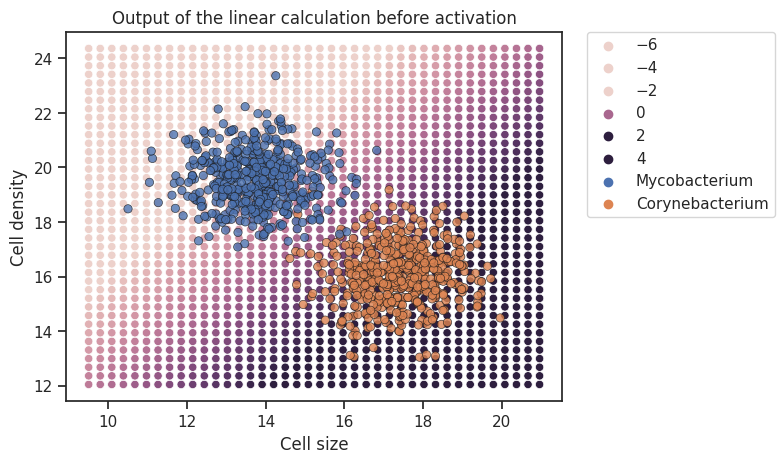

In [15]:
# Plot decision boundary with artificial cells

# Boundaries of plot
x_min = X_total[:, 0].min() - 1
x_max = X_total[:, 0].max() + 1
y_min = X_total[:, 1].min() - 1
y_max = X_total[:, 1].max() + 1

# Array with continous 40 points
x_array = np.linspace(x_min, x_max, 40)
y_array = np.linspace(y_min, y_max, 40)

# Combines every point from array 1 with every point of array 2
xx, yy = np.meshgrid(x_array, y_array)

# Create 2D-array with xx and yy as columns
points = np.column_stack((xx.ravel(), yy.ravel()))

# Calculates output with weights and bias neuron
mesh_output = (points[:,0]*w1 + points[:,1]*w2) + b

# Plot output before going to sigmoid function
sns.scatterplot(x=points[:,0], y=points[:,1], hue=mesh_output, hue_norm=(-2,2))
sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1],hue=y_names, alpha=0.8, edgecolor="k")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title("Output of the linear calculation before activation")
plt.xlabel("Cell size")
plt.ylabel("Cell density");

Now we will transform the different output values by passing them to the **activation function (sigmoid)**.

Remember that the function looks like this:

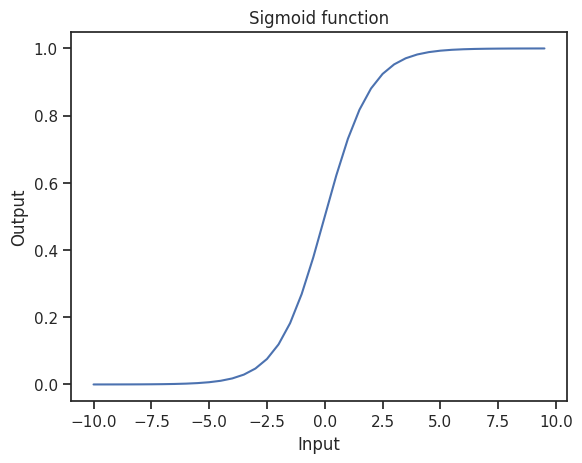

In [16]:
# Generate plot of sigmoid function
x_sigmoid = np.arange(-10,10,0.5)
y_sigmoid = tf.nn.sigmoid(x_sigmoid)
plt.plot(x_sigmoid, y_sigmoid)
plt.title("Sigmoid function")
plt.xlabel("Input")
plt.ylabel("Output");

❓**Question**: How do you expect the activation function to transform the artificial cell values?

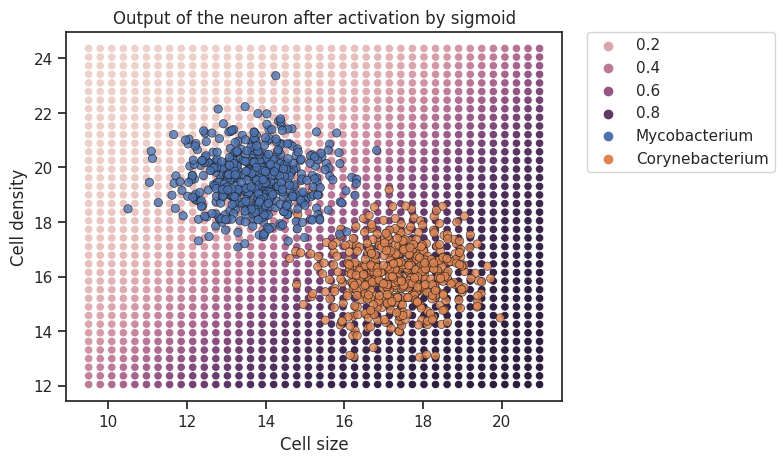

In [17]:
# Pass mesh output to sigmoid
final_output = tf.sigmoid(mesh_output)

# Plot output after sigmoid function
sns.scatterplot(x=points[:,0], y=points[:,1], hue=final_output)
sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1],hue=y_names, alpha=0.8, edgecolor="k")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title("Output of the neuron after activation by sigmoid")
plt.xlabel("Cell size")
plt.ylabel("Cell density");

❓**Question**: Now that you have seen how the model arrives at its conclusions, is this the same method we used at the beginning to separate the two clusters?

Let's compare the actual output of our model to the deconstructed model's output.

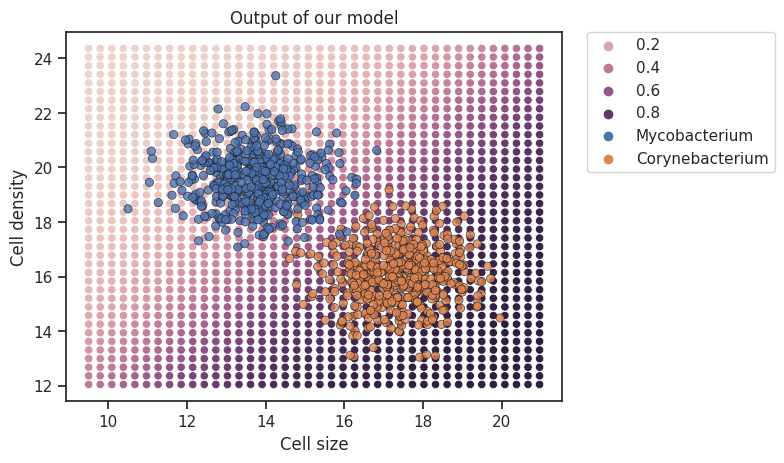

In [18]:
# Calculate and plot decision boundary of model_1
predicted_mesh = tf.squeeze(model_1.predict(points, verbose=0))
sns.scatterplot(x=points[:,0], y=points[:,1], hue=predicted_mesh)
sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1],hue=y_names, alpha=0.8, edgecolor="k")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title("Output of our model")
plt.xlabel("Cell size")
plt.ylabel("Cell density");

**The common visualization technique for classification model decision boundaries is a contour plot. You can think of this as feeding a large number of artificial cells whose parameters change only slightly into the model and plotting its predictions**.

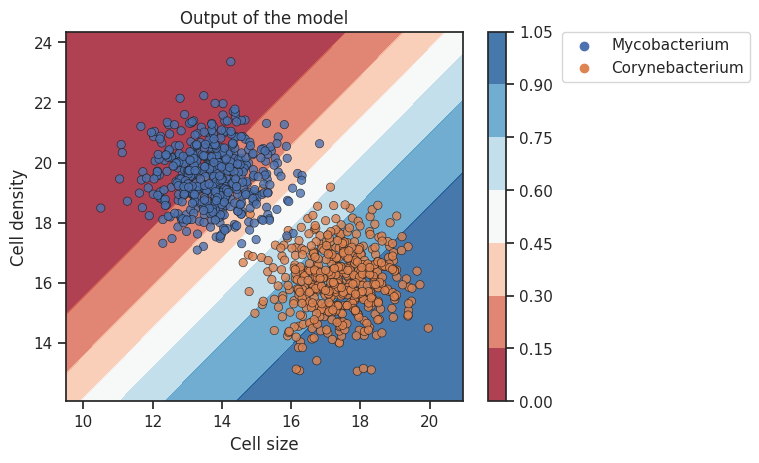

In [19]:
# Reshape the mesh_output back to the grid shape
mesh_output = tf.reshape(predicted_mesh, shape=(xx.shape))

# Plot decision boundary as contour plot
plt.contourf(xx, yy, mesh_output, cmap='RdBu', alpha=0.8)
plt.colorbar()

# Plot data points
sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, alpha=0.8, edgecolor="k")
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left', borderaxespad=0)
plt.title("Output of the model")
plt.xlabel("Cell size")
plt.ylabel("Cell density");

It is important to note that by default, models predict probabilities **>0.5 as 1 and <0.5 as 0**. This means that there is a zone (**twilight zone**) in the decision boundary where the difference between different prediction outcomes is very small and highly influenced by the data (e.g., measurement error).

**In the next plot, the color scheme is adjusted to represent three ranges of values:**
- 0 - 0.45 : High confidence for label 0 (Mycobacterium)
- 0.45 - 0.55: Twilight zone
- 0.55 - 1.0: High confidence for label 1 (Corynebacterium)

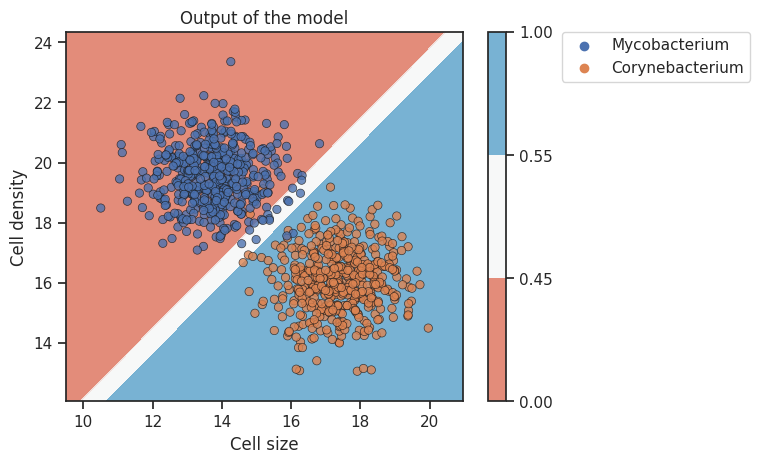

In [20]:
# Plot decision boundary as contour plot scaled to three bins
plt.contourf(xx, yy, mesh_output, cmap='RdBu', alpha=0.8, levels=[0, 0.45, 0.55, 1.0])
plt.colorbar()

# Plot data points
sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, alpha=0.8, edgecolor="k")
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left', borderaxespad=0)
plt.title("Output of the model")
plt.xlabel("Cell size")
plt.ylabel("Cell density");

**Now that we've seen how our model arrives at its predictions, let's evaluate the model's accuracy on the different data set.**

In [21]:
# Predict accuracy for test, validation and train data set
test_accuracy = model_1.evaluate(X_test, y_test, verbose=0)[1]
train_accuracy = model_1.evaluate(X_train, y_train, verbose=0)[1]
val_accuracy = model_1.evaluate(X_val, y_val, verbose=0)[1]
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Validation accuracy: {val_accuracy:.2f}")

Test accuracy: 1.00
Train accuracy: 0.99
Validation accuracy: 0.99


**Now we find and visualize the wrong predictions and check their position on the contour plot.**

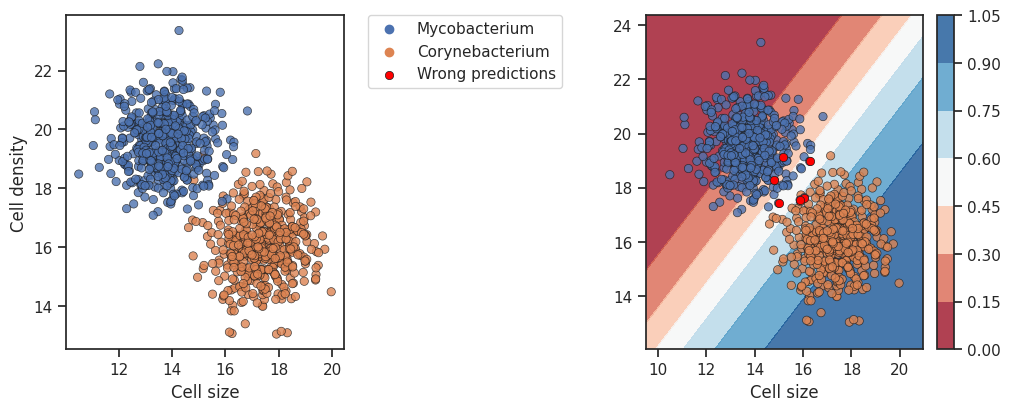

In [22]:
# Find the wrong predictions
predictions_total = tf.round(model_1.predict(X_total, verbose=0))

# Create dataframe with values, y_true and y_pred
data_predictions = {"cell_size" : X_total[:, 0],
        "cell_density" : X_total[:, 1],
        "y_true" : y_total,
        "y_pred" : tf.squeeze(predictions_total)}
predictions_df = pd.DataFrame(data_predictions)

# Filter entries where y_true is not equal to y_pred
wrong_predictions = predictions_df[predictions_df["y_true"] != predictions_df["y_pred"]]

# Visualize data set
fig, ax = plt.subplots(1,2, constrained_layout = True, figsize=(10,4))

# Plot decision boundary as contour plot
contour = ax[1].contourf(xx, yy, mesh_output, cmap='RdBu', alpha=0.8)
plt.colorbar(contour, ax=ax[1])

# Plot scatterplots
sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, ax=ax[0], alpha=0.8, edgecolor="k", legend=None)
sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, ax=ax[1], alpha=0.8, edgecolor="k")
sns.scatterplot(data=wrong_predictions, x="cell_size", y="cell_density", color="red", ax=ax[1], edgecolor="k", label="Wrong predictions")
ax[0].set_xlabel("Cell size")
ax[1].set_xlabel("Cell size")
ax[1].legend(bbox_to_anchor=(-1., 1), loc='upper left', borderaxespad=0)
ax[0].set_ylabel("Cell density")
ax[1].set_ylabel(None);

❓**Question:** Take a close look at the wrong predictions. What do you think was the reason for the wrong prediction?

It is often useful to see how a model makes errors. For example, are the errors evenly distributed across the classes, or is one class in particular being mispredicted as another class?

Since in real-world applications an ANN will never be 100% accurate, it is often important to see how the errors are distributed. Very useful metrics for this are:

> Precision = $\frac {\text{true positives}} {\text{true positives + false positives}}$

> Recall = $\frac {\text{true positives}} {\text{true positives + false negatives}}$

Precision and recall behave antiproportionally over a wide range, and models can be tuned to maximize either metric. Precision is important for the question of whether a positive prediction is really positive. Recall is important for the question of whether all samples that are really positive have been predicted.

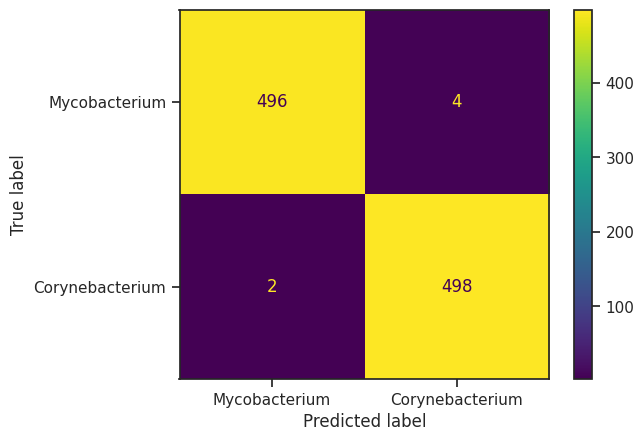

In [23]:
# Calculate and plot confusion matrix
predictions_total = tf.round(model_1.predict(X_total, verbose=0))
ConfusionMatrixDisplay.from_predictions(y_true=y_total,
                                        y_pred=predictions_total,
                                        display_labels=["Mycobacterium", "Corynebacterium"]
                                        );

In [24]:
# Calculate precision and recall score
from sklearn.metrics import precision_score, recall_score
model_1_precision = precision_score(y_true=y_total, y_pred=predictions_total)
model_1_recall = recall_score(y_true=y_total, y_pred=predictions_total)
print(f"model_1 precision score: {100 * model_1_precision:.1f}%")
print(f"model_1 recall score: {100 * model_1_recall:.1f}%")

model_1 precision score: 99.2%
model_1 recall score: 99.6%


Let's say we want to use the model in a detection method for *Mycobacterium tuberculosis*. Cells are sampled from patients, the cell size and cell density are automatically determined, and our model should judge whether the sampled cells could be a *Mycobacterium tuberculosis* cell.

❓**Question:** How would you design a model for this use case in terms of its precision and recall?

We can change the the decision threshold from 0.5 to 0.65 to ensure that the model detects all mycobacterial cells.

model_1 precision score: 100.0%
model_1 recall score: 96.6%


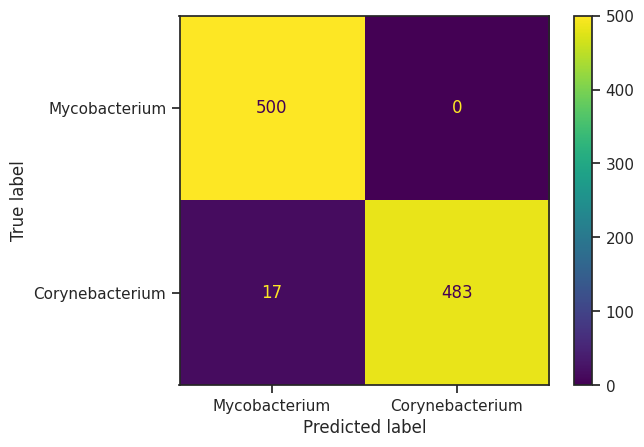

In [29]:
# Calculate precision and recall score
predictions_total_65 = model_1.predict(X_total, verbose=0) >= 0.65
predictions_total_65 = predictions_total_65.astype(int)
model_1_precision = precision_score(y_true=y_total, y_pred=predictions_total_65)
model_1_recall = recall_score(y_true=y_total, y_pred=predictions_total_65)
print(f"model_1 precision score: {100 * model_1_precision:.1f}%")
print(f"model_1 recall score: {100 * model_1_recall:.1f}%")

# Plot confusion matrix with threshold 0.65
ConfusionMatrixDisplay.from_predictions(y_true=y_total,
                                        y_pred=predictions_total_65,
                                        display_labels=["Mycobacterium", "Corynebacterium"]
                                        );

We have seen how a model can predict whether a sample belongs to one class or another. Now we will use the concepts we learned to look at models that predict several different classes.

# Multi-class classification

Exercise: More clusters

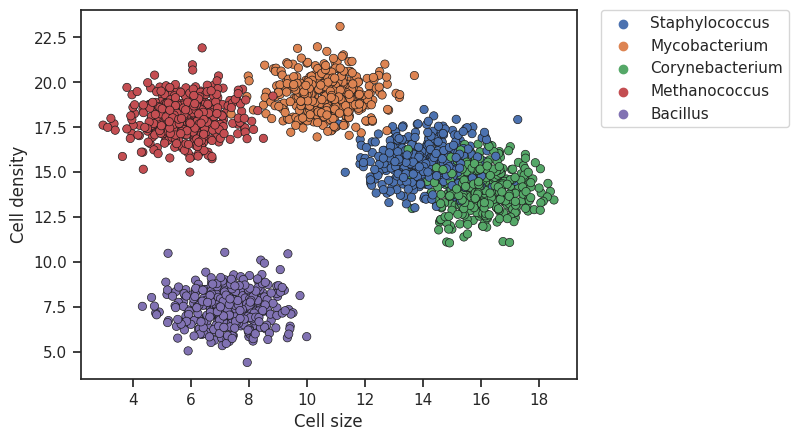

In [ ]:
# Create clusters
X_total, y_total = make_blobs(n_samples=2000,
                              centers=5,
                              center_box=(5,20),
                              cluster_std=1,
                              random_state=42,
                              shuffle=True)

# Create a dictionary to map integer labels to organism names
organism_names_mapping = {
    0: "Mycobacterium",
    1: "Corynebacterium",
    2: "Bacillus",
    3: "Methanococcus",
    4: "Staphylococcus"
}

# Convert labels (0, 1, 2, 3, 4) to names
y_names = [organism_names_mapping[i] for i in y_total]

# Visualize data set
sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, edgecolor="k")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Cell size")
plt.ylabel("Cell density");

In [ ]:
# Split data set into train, test and validation set
X_train, X_test, y_train, y_test = train_test_split(X_total,y_total, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.875)

# Check the split and put all values in datafram
data = [[X_train.shape, len(X_train), 100 * len(X_train) / len(X_total)],
        [y_train.shape, len(y_train), 100 * len(y_train) / len(y_total)],
        [X_test.shape, len(X_test), 100 * len(X_test) / len(X_total)],
        [y_test.shape, len(y_test), 100 * len(y_test) / len(y_total)],
        [X_val.shape, len(X_val), 100 * len(X_val) / len(X_total)],
        [y_val.shape, len(y_val), 100 * len(y_val) / len(y_total)]]
index = ["X_train", "y_train","X_test", "y_test","X_val", "y_val",]
columns = ["Shape", "Elements", "Percentage"]
pd.DataFrame(data=data,
             columns=columns,
             index=index)

Shape  Elements  Percentage
X_train  (1400, 2)      1400        70.0
y_train    (1400,)      1400        70.0
X_test    (400, 2)       400        20.0
y_test      (400,)       400        20.0
X_val     (200, 2)       200        10.0
y_val       (200,)       200        10.0

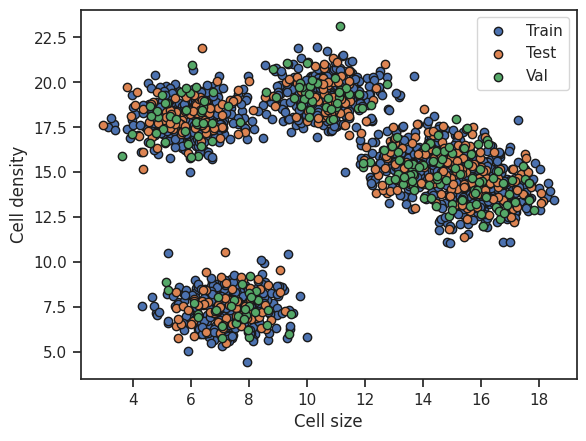

In [ ]:
# Visualize data sets
plt.scatter(X_train[:,0],X_train[:,1], label="Train", edgecolor="k")
plt.scatter(X_test[:,0],X_test[:,1], label="Test", edgecolor="k")
plt.scatter(X_val[:,0],X_val[:,1], label="Val", edgecolor="k")
plt.legend()
plt.xlabel("Cell size")
plt.ylabel("Cell density");

<img src="https://github.com/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Images/Multiclass%20classification%20model%201.jpg?raw=true" width="740" height="460" />

In [ ]:
# Set up random seed for reproducibility
tf.random.set_seed(42)

# Create model
model_2 = keras.Sequential([
    keras.Input(shape=(X_train.shape[1:])),
    layers.Dense(units=5,activation="softmax")])

model_2.summary()

# Compile model
model_2.compile(optimizer="sgd",
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

# Fit model
history_2 = model_2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 5)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
44/44 [==============================] - 1s 6ms/step - loss: 1.7684 - accuracy: 0.3514 - val_loss: 1.2220 - val_accuracy: 0.2750
Epoch 2/10
44/44 [==============================] - 0s 2ms/step - loss: 1.1173 - accuracy: 0.4957 - val_loss: 0.9688 - val_accuracy: 0.6350
Epoch 3/10
44/44 [==============================] - 0s 3ms/step - loss: 0.9461 - accuracy: 0.6500 - val_loss: 0.8632 - val_accuracy: 0.7150
Epoch 4/10
44/44 [==============================] - 0s 4ms/step - loss: 0.8589 - accuracy: 0.6914 - val_loss: 0.7754 - val_accuracy: 0.7900
Epoch 5/10
44/44 [========

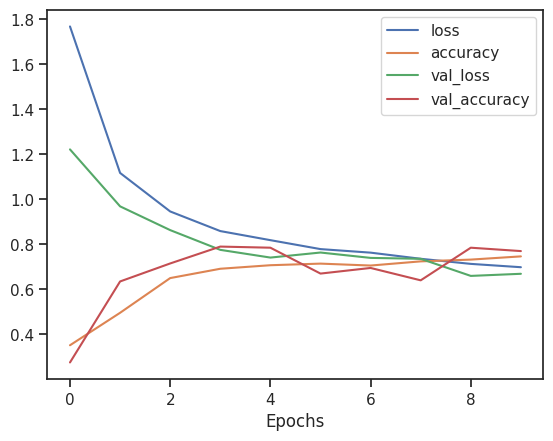

In [ ]:
# Plot accuracies and losses over epochs
pd.DataFrame(history_2.history).plot()
plt.xlabel("Epochs");

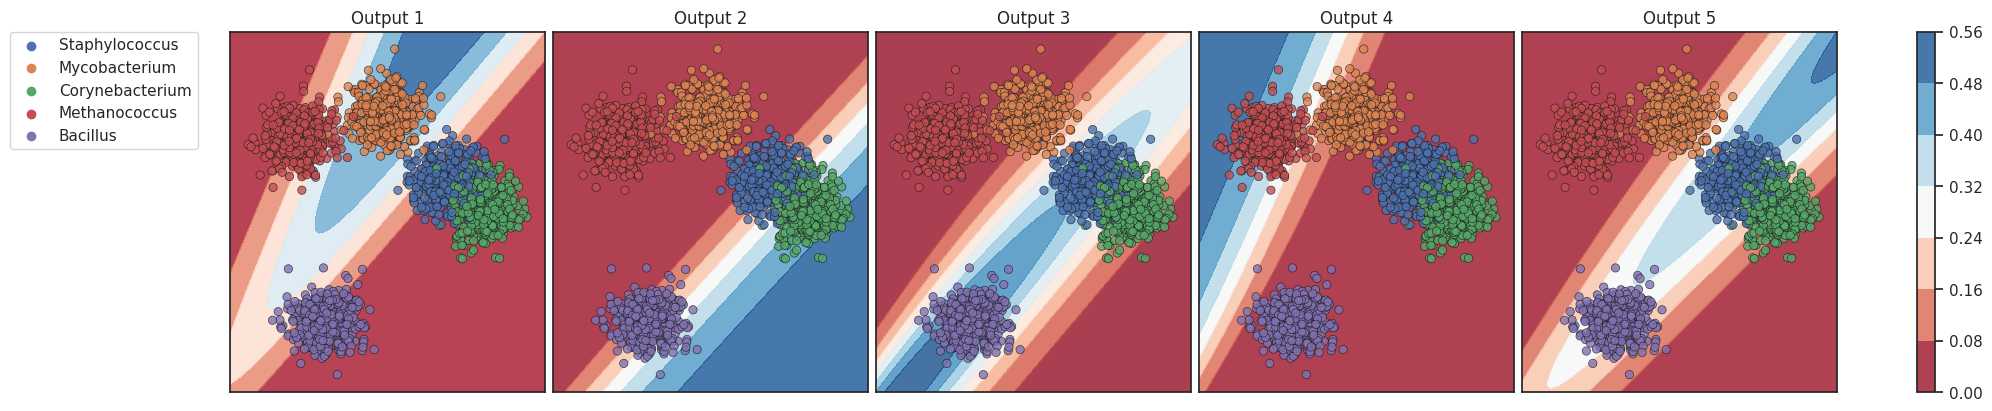

In [ ]:
# Predict decision boundary

# Boundaries of plot
x_min = X_total[:, 0].min() - 1
x_max = X_total[:, 0].max() + 1
y_min = X_total[:, 1].min() - 1
y_max = X_total[:, 1].max() + 1

# Array with continous 100 points
x_array = np.linspace(x_min, x_max, 100)
y_array = np.linspace(y_min, y_max, 100)

# Combines every point from array 1 with every point of array 2
xx, yy = np.meshgrid(x_array, y_array)

# Create 2D-array with xx and yy as columns
points = np.column_stack((xx.ravel(), yy.ravel()))

# Predict output using meshgrid as input
mesh_output = model_2.predict(points, verbose=0)

# Split the output into the 5 probability channels
probability_channels = [tf.reshape(mesh_output[:, i], xx.shape) for i in range(5)]

# Output titles for plots
output_titles = ["Output 1", "Output 2", "Output 3", "Output 4", "Output 5"]

# Visualize data set
fig, axes = plt.subplots(1,5, constrained_layout = True, figsize=(20,4))

# Plot decision boundary and scatterplots
for i, ax in enumerate(axes):
    # Plot decision boundary as contour plot
    cnt = ax.contourf(xx, yy, probability_channels[i], cmap='RdBu', alpha=0.8)
    ax.set_title(output_titles[i])
    # Plot scatterplot and only display legend for first subplot
    if i == 0:
      sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, ax=ax, alpha=0.8, edgecolor="k")
      ax.legend(bbox_to_anchor=(-0.7, 1), loc='upper left', borderaxespad=0)
    else:
      sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, ax=ax, alpha=0.8, edgecolor="k", legend=None)
    # Remove axes labels and ticks
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

# Add a single colorbar for all subplots
plt.colorbar(cnt, ax=axes);

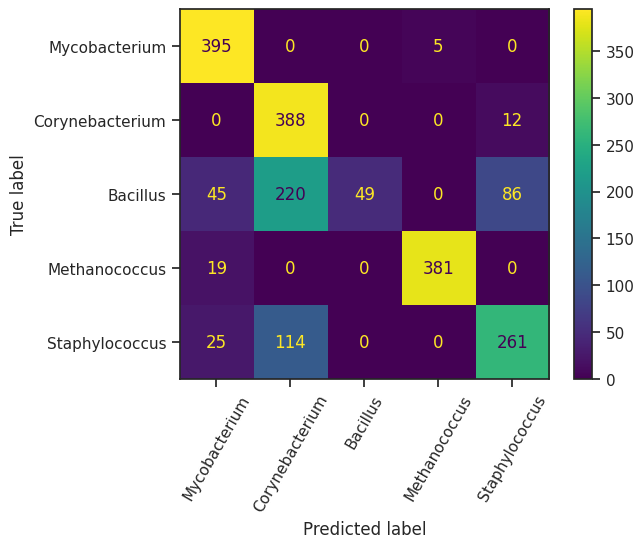

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=y_total,
                                        y_pred=predictions_total.argmax(axis=1),
                                        display_labels=organism_names_mapping.values(),
                                        xticks_rotation=60
                                        );

Blackbox problem

In [ ]:
# Extract weights and biases from model and put them in dataframe
model_2_weights_x, model_2_weights_y = model_2.get_weights()[0]
model_2_biases = model_2.get_weights()[1]
weights_biases_df = pd.DataFrame([model_2_weights_x, model_2_weights_y, model_2_biases],
                                 index=["x_weights", "y_weights", "bias_vectors"],
                                 columns=list(range(1,6))).transpose()

weights_biases_df

x_weights  y_weights  bias_vectors
1  -0.203632   0.393087     -0.116159
2   0.913073  -0.568747     -0.159621
3   0.373405  -0.122555      0.383834
4  -0.926617   0.686944      0.018579
5   0.359230  -0.041932     -0.126633

Exercise: Improve basic model

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 8,837
Trainable params: 8,837
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
44/44 [==============================] - 1s 7ms/step - loss: 1.3806 - accuracy: 0.5743 - val_loss: 1.1384 - val_accuracy: 0.7300
Epoch 2/150
44/44 [=============================

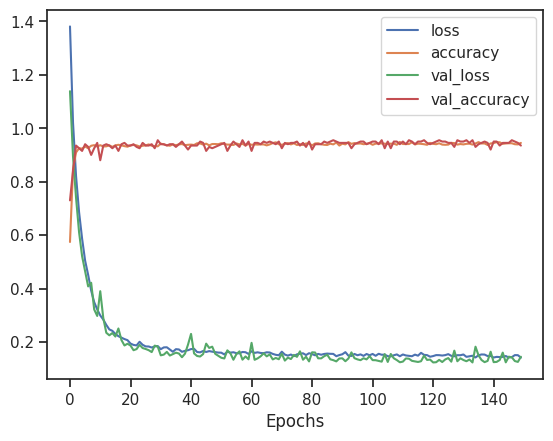

In [ ]:
# Fill out the hyperparameters

# units_i is the number of neurons in layer i. Typical values are 0-100
units_1 = 64
units_2 = 64
units_3 = 64
units_output = 5
# activation_i is the activation function for layer i. You can use "relu", "tanh", "softmax"
activation_1 ="tanh"
activation_2 ="relu"
activation_3 ="tanh"
activation_output ="softmax"
# epochs
epochs = 150


# Set up random seed for reproducibility
tf.random.set_seed(42)

# Build model
model_3 = keras.Sequential([layers.Dense(units=units_1, activation=activation_1, input_shape=X_train.shape[1:]),
                            layers.Dense(units=units_2, activation=activation_2),
                            layers.Dense(units=units_3, activation=activation_3),
                            layers.Dense(units=units_output, activation=activation_output)],
                            name="Model_3")

model_3.summary()

# Compile model
model_3.compile(optimizer="sgd",
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

# Fit model
history_3 = model_3.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

# Plot accuracies and losses over epochs
pd.DataFrame(history_3.history).plot()
plt.xlabel("Epochs");

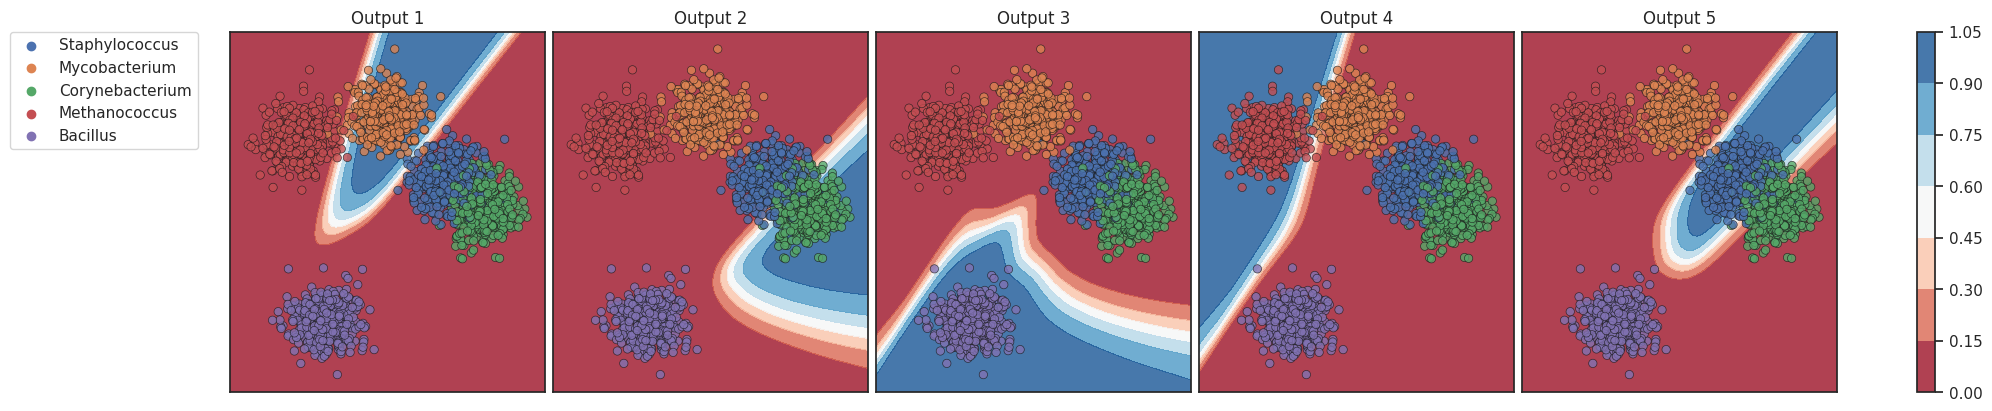

In [ ]:
# Predict decision boundary

# Boundaries of plot
x_min = X_total[:, 0].min() - 1
x_max = X_total[:, 0].max() + 1
y_min = X_total[:, 1].min() - 1
y_max = X_total[:, 1].max() + 1

# Array with continous 100 points
x_array = np.linspace(x_min, x_max, 100)
y_array = np.linspace(y_min, y_max, 100)

# Combines every point from array 1 with every point of array 2
xx, yy = np.meshgrid(x_array, y_array)

# Create 2D-array with xx and yy as columns
points = np.column_stack((xx.ravel(), yy.ravel()))

# Predict output using meshgrid as input
mesh_output = model_3.predict(points, verbose=0)

# Split the output into the 5 probability channels
probability_channels = [tf.reshape(mesh_output[:, i], xx.shape) for i in range(5)]

# Output titles for plots
output_titles = ["Output 1", "Output 2", "Output 3", "Output 4", "Output 5"]

# Visualize data set
fig, axes = plt.subplots(1,5, constrained_layout = True, figsize=(20,4))

# Plot decision boundary and scatterplots
for i, ax in enumerate(axes):
    # Plot decision boundary as contour plot
    cnt = ax.contourf(xx, yy, probability_channels[i], cmap='RdBu', alpha=0.8)
    ax.set_title(output_titles[i])
    # Plot scatterplot and only display legend for first subplot
    if i == 0:
      sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, ax=ax, alpha=0.8, edgecolor="k")
      ax.legend(bbox_to_anchor=(-0.7, 1), loc='upper left', borderaxespad=0)
    else:
      sns.scatterplot(x=X_total[:, 0], y=X_total[:, 1], hue=y_names, ax=ax, alpha=0.8, edgecolor="k", legend=None)
    # Remove axes labels and ticks
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

# Add a single colorbar for all subplots
plt.colorbar(cnt, ax=axes);

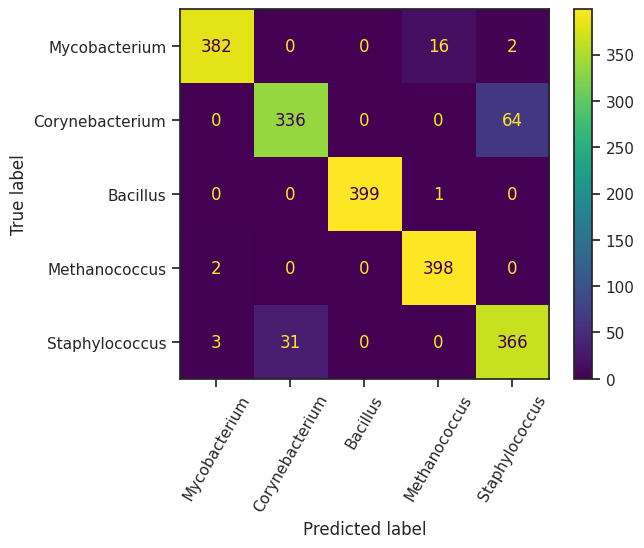

In [ ]:
# Plot confusion matrix
predictions_total = model_3.predict(X_total, verbose=0)
ConfusionMatrixDisplay.from_predictions(y_true=y_total,
                                        y_pred=predictions_total.argmax(axis=1),
                                        display_labels=organism_names_mapping.values(),
                                        xticks_rotation=60
                                        );

When you are happy with your model, evaluate it finally on the test data set and compare it to model_2.

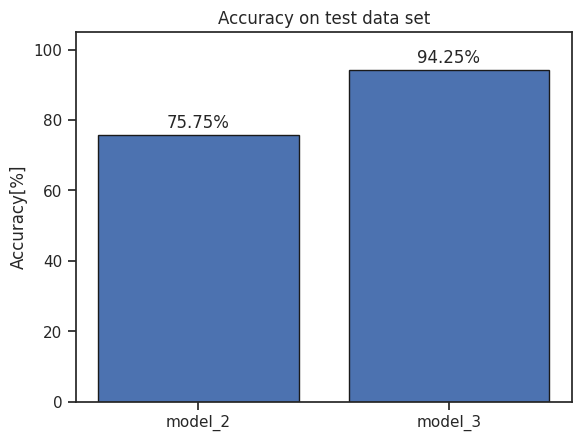

In [ ]:
# Evaluate model_2 and model_3 on test data set
model_2_eval = model_2.evaluate(X_test, y_test, verbose=0)[1] * 100
model_3_eval = model_3.evaluate(X_test, y_test, verbose=0)[1] * 100
plt.bar(x=["model_2", "model_3"], height=[model_2_eval, model_3_eval], edgecolor="k")
plt.title("Accuracy on test data set")
plt.ylabel("Accuracy[%]")
plt.ylim(0,105)

# Annotate each bar with its accuracy value
for i, v in enumerate([model_2_eval, model_3_eval]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

# Image classification with the MNIST dataset

In [ ]:
from keras.datasets import mnist

# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Check how the data is organized
print(f"train_data shape: {train_data.shape}")
print(f"train_labels shape: {train_labels.shape}")
print(f"test_data shape: {test_data.shape}")
print(f"test_labels shape: {test_labels.shape}")

train_data shape: (60000, 28, 28)
train_labels shape: (60000,)
test_data shape: (10000, 28, 28)
test_labels shape: (10000,)


In [ ]:
# Check how one picture looks like
train_data[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [ ]:
# What is the minimum and the maximum value?
print(f"Pixel values in range: {train_data[0].min()} - {train_data[0].max()}")

Pixel values in range: 0 - 255


Label: 5


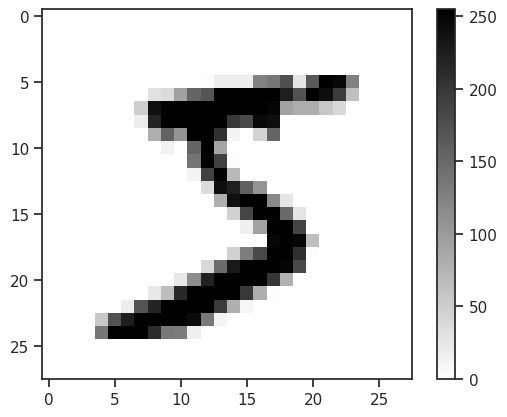

In [ ]:
# Plot first image and label
plt.imshow(train_data[0], cmap=plt.cm.binary)
plt.colorbar()
print(f"Label: {train_labels[0]}")

Think about why you can classify this picture as a picture of a 5.

In [ ]:
# Normalize data
print(f"Minimum pixel value: {train_data[0].min()} and maximum pixel value: {train_data[0].max()}")

train_data_normalized = train_data / train_data[0].max()
test_data_normalized = test_data / train_data[0].max()

print(train_data_normalized[0])

Minimum pixel value: 0 and maximum pixel value: 255
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0. 

In [ ]:
# Set random set
tf.random.set_seed(42)

# Create model without normalization
model_1 = keras.Sequential([
    layers.Flatten(input_shape=train_data.shape[1:]), #Flattens every picture to a 1D-array with 28x28 = 784 values
    layers.Dense(10, activation="softmax")
    ])

model_1.summary()

# Compile model

model_1.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                       optimizer=keras.optimizers.Adam(),
                       metrics=["accuracy"])

# Train model

history_1 = model_1.fit(train_data, train_labels, epochs=10, batch_size=32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 9.7573 - accuracy: 0.8379
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 6.0870 - accuracy: 0.8796
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 5.6660 - accuracy: 0.8810
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 5.5816 - accuracy: 0.8850
Epoch 5/10
1875/1875 [==================

In [ ]:
# Set random set
tf.random.set_seed(42)

# Create model without normalization
model_1_normalized = keras.Sequential([
    layers.Flatten(input_shape=train_data.shape[1:]), #Flattens every picture to a 1D-array with 28x28 = 784 values
    layers.Dense(10, activation="softmax")
    ])

model_1_normalized.summary()

# Compile model

model_1_normalized.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                       optimizer=keras.optimizers.Adam(),
                       metrics=["accuracy"])

# Train model

history_1_normalized = model_1_normalized.fit(train_data_normalized, train_labels, epochs=10, batch_size=32)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4683 - accuracy: 0.8765
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3036 - accuracy: 0.9154
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2830 - accuracy: 0.9209
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2727 - accuracy: 0.9238
Epoch 5/10
1875/1875 [==================

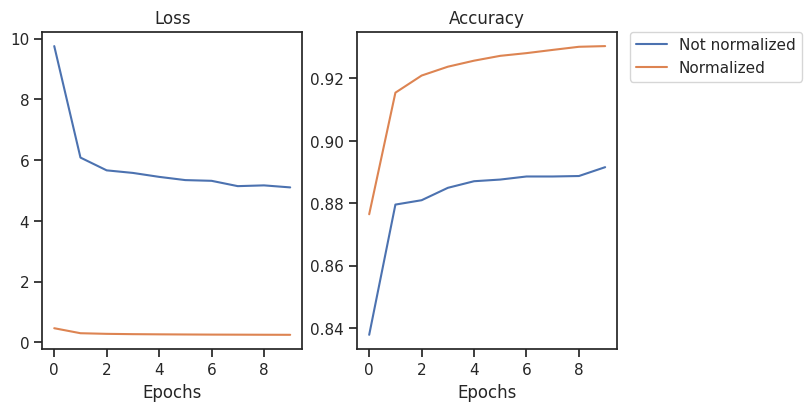

In [ ]:
# Plot training of normalized and non-normalized model
fig, axes = plt.subplots(1,2, layout="constrained", figsize=(8,4))
axes[0].plot(history_1.history["loss"], label="Not normalized")
axes[1].plot(history_1.history["accuracy"], label="Not normalized")
axes[0].plot(history_1_normalized.history["loss"], label="Normalized")
axes[1].plot(history_1_normalized.history["accuracy"], label="Normalized")
axes[0].set_title("Loss")
axes[1].set_title("Accuracy")

for ax in axes:
  ax.set_xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

1875/1875 [==============================] - 3s 1ms/step


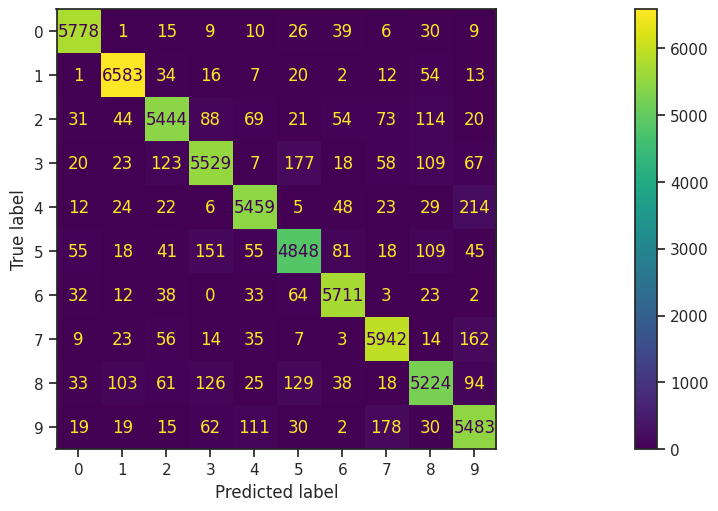

In [ ]:
# Calculate and plot confusion matrix of best model
model_1_predictions = model_1_normalized.predict(train_data_normalized)
fig, axes = plt.subplots(figsize=(30,5), layout="constrained")
ConfusionMatrixDisplay.from_predictions(y_true=train_labels,
                                        y_pred=model_1_predictions.argmax(axis=1),
                                        ax=axes
                                        );

In [ ]:
# Dataframe with true labels and predictions for train data
# Index is index in train_data
predictions_df =pd.DataFrame({"true_label" : train_labels,
                              "prediction" : model_1_predictions.argmax(axis=1)})

# Subdataframe with wrong predictions and sort
predictions_df_wrong = predictions_df[
    (predictions_df["true_label"] != predictions_df["prediction"])
    ].sort_values("true_label")

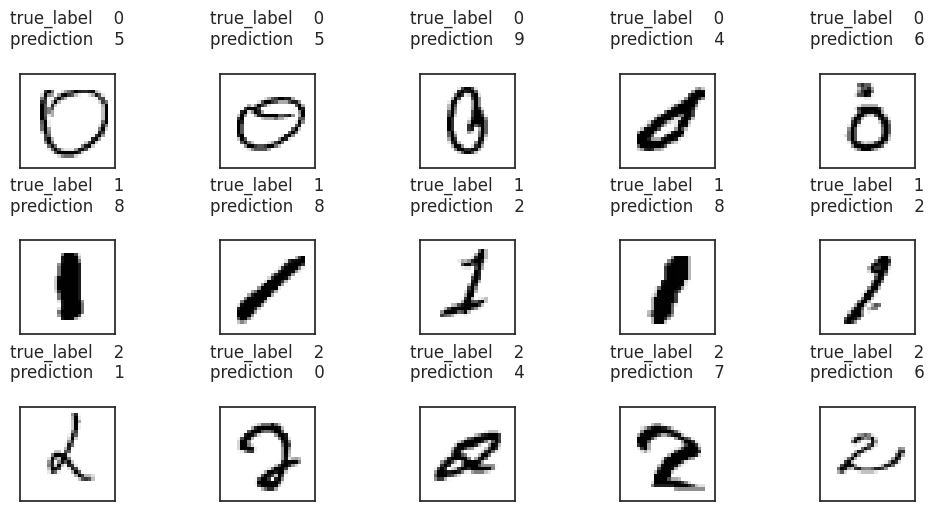

In [ ]:
# Plot first image and label
fig, axes = plt.subplots(3,5, layout="constrained", figsize=(10,5))
# Fill first row with examples of true_label = 0
for i in range(5):
  index_list = predictions_df_wrong[predictions_df_wrong["true_label"] == 0].iloc[0:5].index
  axes[0,i].imshow(train_data_normalized[index_list[i]], cmap=plt.cm.binary)
  axes[0,i].set_title(str(predictions_df_wrong.loc[index_list[i]]).split("Name")[0])
  axes[0,i].set_xticks([])
  axes[0,i].set_yticks([])
# Fill second row with examples of true_label = 1
for i in range(5):
  index_list = predictions_df_wrong[predictions_df_wrong["true_label"] == 1].iloc[0:5].index
  axes[1,i].imshow(train_data_normalized[index_list[i]], cmap=plt.cm.binary)
  axes[1,i].set_title(str(predictions_df_wrong.loc[index_list[i]]).split("Name")[0])
  axes[1,i].set_xticks([])
  axes[1,i].set_yticks([])
# Fill 3 row with examples of true_label = 2
  index_list = predictions_df_wrong[predictions_df_wrong["true_label"] == 2].iloc[0:5].index
  axes[2,i].imshow(train_data_normalized[index_list[i]], cmap=plt.cm.binary)
  axes[2,i].set_title(str(predictions_df_wrong.loc[index_list[i]]).split("Name")[0])
  axes[2,i].set_xticks([])
  axes[2,i].set_yticks([])

Improve model exercise

In [ ]:
# Set random set
tf.random.set_seed(42)

# Create model without normalization
model_2 = keras.Sequential([
    layers.Flatten(input_shape=train_data.shape[1:]),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(10, activation="softmax")
    ])

model_2.summary()

# Compile model
model_2.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                       optimizer=keras.optimizers.Adam(),
                       metrics=["accuracy"])

# Train model
history_2 = model_2.fit(train_data_normalized, train_labels, validation_split=0.1, epochs=10, batch_size=32)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 16)                12560     
                                                                 
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 dense_10 (Dense)            (None, 10)                170       
                                                                 
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1688/1688 [==============================] - 5s 2ms/step - loss: 0.4731 - accuracy: 0.8606 - val_loss: 0.2265 - val_accuracy: 0.9362
Epoch 2/10
1688/1688 [================

<Axes: >

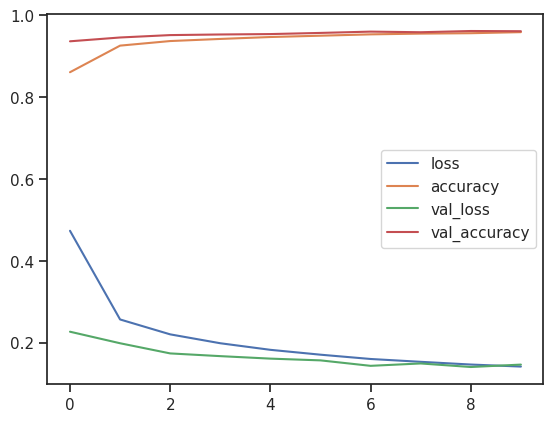

In [ ]:
pd.DataFrame(history_2.history).plot()

1875/1875 [==============================] - 4s 2ms/step


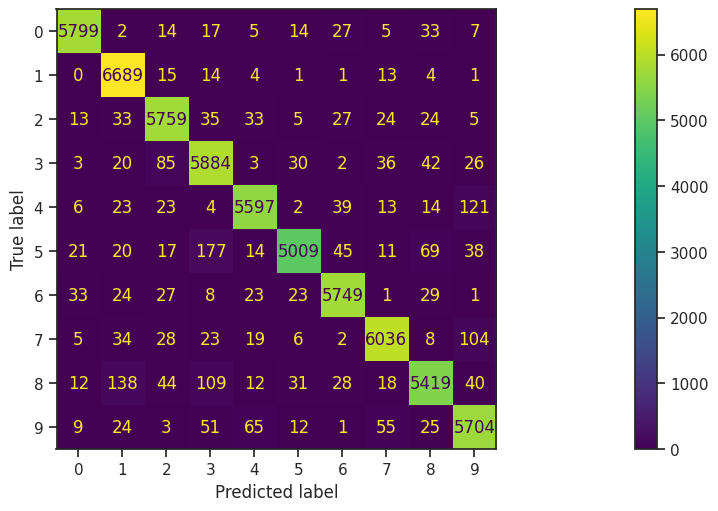

In [ ]:
# Calculate and plot confusion matrix of best model

model_2_predictions = model_2.predict(train_data_normalized)
fig, axes = plt.subplots(figsize=(30,5), layout="constrained")
ConfusionMatrixDisplay.from_predictions(y_true=train_labels,
                                        y_pred=model_2_predictions.argmax(axis=1),
                                        ax=axes
                                        );

Visualize wrong predictions

In [ ]:
# Load image, convert it to grayscale and scale it
#!wget "https://as1.ftcdn.net/v2/jpg/02/08/82/66/1000_F_208826694_K5OrORWSv7Fs6X3x2xHnNpwNbol6OslY.jpg"
image = plt.imread("/content/Handwritten 6.jpg")
image = tf.image.rgb_to_grayscale(image)
image = image / 255
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar();

FileNotFoundError: ignored

In [ ]:
# Predict class of image with model_2 and plot probabilities
prediction_eleven = model_2.predict(tf.expand_dims(image, axis=0), verbose=0)
prediction_eleven.shape
plt.bar(height=prediction_eleven[0], x=list(range(10)))
plt.ylabel("Probability")
plt.xticks(list(range(10)));

The model cannot predict the 6. Compare image with others.

In [ ]:
# Inverse image
image = 1 - image
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar();

In [ ]:
# Predict class of image with model_2 and plot probabilities
prediction_eleven = model_2.predict(tf.expand_dims(image, axis=0), verbose=0)
prediction_eleven.shape
plt.bar(height=prediction_eleven[0], x=list(range(10)))
plt.ylabel("Probability")
plt.xticks(list(range(10)));

Image of 11

In [ ]:
# Load image, convert it to grayscale, scale it and inverse it
#!wget "https://as1.ftcdn.net/v2/jpg/02/08/82/66/1000_F_208826694_K5OrORWSv7Fs6X3x2xHnNpwNbol6OslY.jpg"
image = plt.imread("/content/Handwritten 11.jpg")
image = tf.image.rgb_to_grayscale(image)
image = image / 255
image = 1 - image
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar();

In [ ]:
# Predict class of image with model_2 and plot probabilities
prediction_eleven = model_2.predict(tf.expand_dims(image, axis=0), verbose=0)
prediction_eleven.shape
plt.bar(height=prediction_eleven[0], x=list(range(10)))
plt.ylabel("Probability")
plt.xticks(list(range(10)));